In [381]:
import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [382]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
# import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
# from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, ImplicitRNNCellLoRA
from implicitdl import *

In [383]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:2") 
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
torch.set_default_device(device)
generator = torch.Generator(device=device)

GPU is available


In [384]:
import numpy as np
import matplotlib.pyplot as plt

generate_data = 1
level = 6

input_dim_gt = level*3
hidden_dim_gt = level*5
output_dim_gt = level*2

np.random.seed(1)
torch.manual_seed(1)

den = 5
Agt = nn.Parameter(torch.randn(hidden_dim_gt, hidden_dim_gt)/den)
Bgt = nn.Parameter(torch.randn(hidden_dim_gt, input_dim_gt))
Cgt = nn.Parameter(torch.randn(output_dim_gt, hidden_dim_gt))
Dgt = nn.Parameter(torch.randn(output_dim_gt, input_dim_gt))
gt_model = ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf).eval()
# initialize the model with the random matrices
gt_model.A = Agt
gt_model.B = Bgt
gt_model.C = Cgt
gt_model.D = Dgt

n_samples = level*10000
n_samples_val = 200

if generate_data:
    # generate data for training and validation using gt_mode
    x_values = torch.randn(n_samples, input_dim_gt)*10
    y_values = gt_model(x_values)
    x_values_val = torch.randn(n_samples_val, input_dim_gt)*10
    y_values_val = gt_model(x_values_val)
    # save the data to npz file
    np.savez(f'./kaggle/input/synthetic_fp_data_h{hidden_dim_gt}.npz', x_values=x_values.detach().cpu(), y_values=y_values.detach().cpu(), x_values_val=x_values_val.detach().cpu(), y_values_val=y_values_val.detach().cpu())
    # print(x_values[:5], y_values[:5])

# load from the npz file
data = np.load(f'./kaggle/input/synthetic_fp_data_h{hidden_dim_gt}.npz')
x_values = torch.tensor(data['x_values']).to(device)
y_values = torch.tensor(data['y_values']).to(device)
# print(x_values[:5], y_values[:5])
x_values_val = torch.tensor(data['x_values_val']).to(device)
y_values_val = torch.tensor(data['y_values_val']).to(device)
# into data_loader
training_set = TensorDataset(x_values, y_values)
validation_set = TensorDataset(x_values_val, y_values_val)

# Model

In [385]:
from typing import Optional

   
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)

# Define and train Model

In [386]:
def train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn):
    running_loss = 0.
    last_loss = 0.
    for t, data in enumerate(training_loader):
        x_train, y_train = data
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_fn(y_train_pred, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (t % 10 == 9):
            last_loss = running_loss / 10 # loss per batch
            running_loss = 0.
    return last_loss

def plot_hist(y_axis, xlabel, ylabel, title, x_axis=None, log=False):
    plt.figure()
    if (x_axis is None):
        x_axis = range(len(y_axis))
    if log:
        plt.semilogy(x_axis, y_axis)
    else:
        plt.plot(x_axis, y_axis)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


def evaluate_model(model, validation_loader):
    # Disable gradient computation and reduce memory consumption.
    running_vloss = 0.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels).item()
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    return avg_vloss

In [387]:
make_imp = lambda: ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf, no_D=False, bias=False)
make_mlp = lambda: MLP(input_dim_gt, 14, output_dim_gt, act=nn.ReLU)

In [388]:
batch_size = 512
EPOCHS = 90
RUNS = 1

torch.manual_seed(2)
# format data for training to dataloader
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, generator=generator)
loss_fn = torch.nn.MSELoss()
generator = torch.Generator(device=device)

best_vloss = 1_000_000.
for run_idx in range(RUNS):
    # model, lr = make_mlp().to(device), 0.01; #torch.nn.init.normal_(fuse_parameters(model))
    model, lr = make_imp().to(device), 0.07; torch.nn.init.normal_(fuse_parameters(model), mean=0, std=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    # print(model)
    if run_idx == 0:
        print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')
    
    avg_vloss_all = []
    avg_loss_all = []
    up_count = 0
    for epoch in range(EPOCHS):
        model.train(True)    
        avg_loss = train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn)
        avg_loss_all.append(avg_loss)
        scheduler.step()

        model.eval()
        avg_vloss = evaluate_model(model, validation_loader)
        avg_vloss_all.append(avg_vloss)
        print(f'Epoch {epoch} loss: {avg_loss}, val loss: {avg_vloss}')

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_model = model
            up_count = 0
        else:
            up_count += 1
        
        if up_count > 15:
            break
    print(f'Run {run_idx} best val loss: {best_vloss}')
# print(f'r2 (higher better):    {np.mean(r2s):.2f} +- {np.std(r2s):.2f}')
# print(f'MAPE (smaller better): {np.mean(mapes):.2f} +- {np.std(mapes):.2f}')
# ############# can calibrate size of RNN to compartible with imp_rnn
# best_r2_index = np.argmax(r2s)
# best_mape_index = np.argmin(mapes)

# print(f'Best r2 (higher better):    {r2s[best_r2_index]:.2f} at iteration {best_r2_index}')
# print(f'Best MAPE (smaller better): {mapes[best_mape_index]:.2f} at iteration {best_mape_index}')

model size: 2016 parameters


Epoch 0 loss: 1226.4986938476563, val loss: 1055.1090087890625
Epoch 1 loss: 349.01184997558596, val loss: 320.42401123046875
Epoch 2 loss: 127.84848327636719, val loss: 137.97727966308594
Epoch 3 loss: 109.8891700744629, val loss: 116.62921905517578
Epoch 4 loss: 79.99563674926758, val loss: 79.85226440429688
Epoch 5 loss: 65.63006629943848, val loss: 74.69743347167969
Epoch 6 loss: 62.85688514709473, val loss: 69.58204650878906
Epoch 7 loss: 63.089437103271486, val loss: 70.63575744628906
Epoch 8 loss: 61.21872482299805, val loss: 65.78498840332031
Epoch 9 loss: 62.79962577819824, val loss: 71.1249008178711
Epoch 10 loss: 59.895072555541994, val loss: 72.54431915283203
Epoch 11 loss: 62.2890079498291, val loss: 70.79060363769531
Epoch 12 loss: 64.17440567016601, val loss: 70.09142303466797
Epoch 13 loss: 64.2147117614746, val loss: 73.09956359863281
Epoch 14 loss: 61.64403457641602, val loss: 67.79792785644531
Epoch 15 loss: 61.07479019165039, val loss: 73.22162628173828
Epoch 16 los

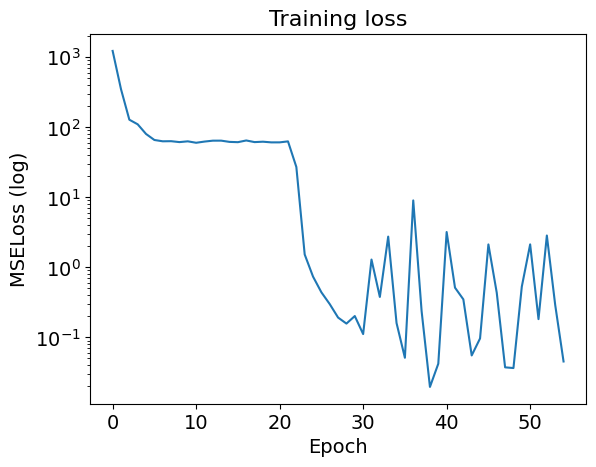

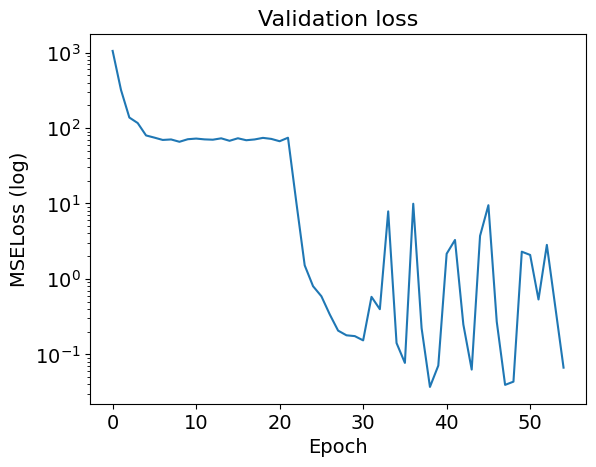

In [389]:
plot_hist(avg_loss_all, 'Epoch', 'MSELoss (log)', 'Training loss', log=True)
plot_hist(avg_vloss_all, 'Epoch', 'MSELoss (log)', 'Validation loss', log=True)

In [390]:
if isinstance(best_model, ImplicitModel):
    # compare model.A with gt_model.A
    print("A", best_model.A.cpu().detach().numpy())
    print("Agt",gt_model.A.cpu().detach().numpy())
    print("D",best_model.D.cpu().detach().numpy())
    print("Dgt",gt_model.D.cpu().detach().numpy())

    print((best_model.A - gt_model.A).norm().item())
    print((best_model.B - gt_model.B).norm().item())
    print((best_model.C - gt_model.C).norm().item())
    print((best_model.D - gt_model.D).norm().item())


A [[-0.13107869 -1.1361554   3.28291    -1.6509277  -1.4119354  -1.6837208
   0.09753436 -1.4153475  -2.5282948   3.0939548   0.5789416  -0.6882582
  -1.3327376   1.2854539   3.570527   -2.5722353   3.773541   -3.6443496
  -1.6235095   1.4926912   0.1779456   0.3675065   0.26345238  0.06743514
   2.0666     -1.7019509  -1.6785979   1.2163043   1.8536836   4.8091364 ]
 [-2.8104424  -0.3702443  -1.4273753   1.601975   -1.6808485  -1.0545461
   2.961489    3.1795983  -1.1657956  -1.2897532   3.0744112  -0.06866041
   1.1271595   2.4977574   3.0722723   0.12788263  2.1847513  -1.7332926
   0.06133091 -1.0132644  -1.7357172  -0.8489215   2.2444844   0.08411609
   1.7365018   0.9499222  -1.2382843  -1.9702201  -2.021931   -2.9092119 ]
 [-3.3555057  -2.5366235  -0.19622098 -2.3321984  -1.7064263  -0.55994946
   0.40840146  3.2173536  -2.514053    1.5332105   2.3656416  -0.6729535
  -1.9139522  -0.95407903  2.7918036  -1.3489453   1.787475   -2.7415788
   2.6050386  -0.838507   -2.0185654   0.

In [396]:
x_test = torch.randn(1, input_dim_gt)*10000
# x_test = x_values[np.random.randint(0, n_samples)].unsqueeze(0)
y_test = gt_model(x_test)
y_test_pred = best_model(x_test)
print(f'x_test: {x_test.detach().cpu().numpy()}')
print(f'y_test: {y_test.detach().cpu().numpy()}')
print(f'y_test_pred: {y_test_pred.detach().cpu().numpy()}')

running_mape = 0.
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = best_model(vinputs)
        mape = ((voutputs - vlabels).norm(dim=1) / vlabels.norm(dim=1)).mean()
        running_mape += mape
avg_mape = running_mape / (i + 1)
print(f'level: {level}, avg mape: {avg_mape}')
print(gt_model.A[-1,0])

x_test: [[  2883.921    5220.1885  -2245.9336  11042.712    6739.7065 -15290.066
     419.7572  -4017.9138  -7889.028   15085.12     2489.1687 -11865.405
   20867.55    10142.265    6185.46   -14189.588   15410.257  -10608.047 ]]
y_test: [[  39071.56  -257608.69   201740.     -34093.14    78651.52    16970.977
   209950.11   -47661.297  -45205.35   247427.6     90529.484  135415.67 ]]
y_test_pred: [[  39113.758 -257552.17   201684.67   -33955.766   78670.625   17027.043
   209735.33   -47453.61   -45061.617  247216.48    90757.016  135243.78 ]]
level: 6, avg mape: 0.0014613696839660406
tensor(-0.0593, device='cuda:0', grad_fn=<SelectBackward0>)


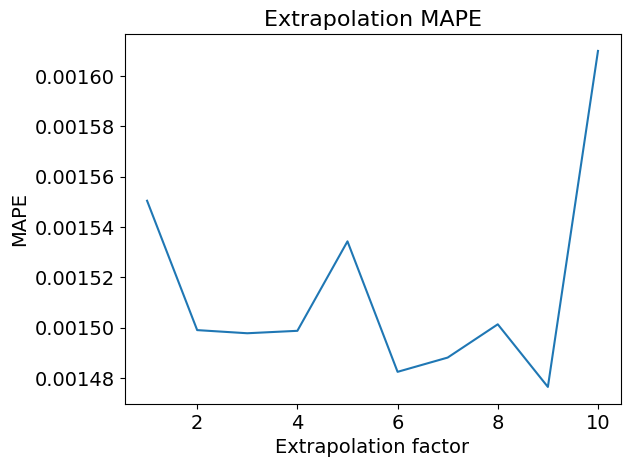

In [394]:
extrap_level = 1
extrap_max = 10
mapes = []

with torch.no_grad():
    for ood_level in range(extrap_max):
        x_ood = torch.randn(n_samples_val, input_dim_gt)*10**extrap_level
        y_ood = gt_model(x_ood)
        y_ood_pred = best_model(x_ood)
        mape = ((y_ood - y_ood_pred).norm(dim=1) / y_ood_pred.norm(dim=1)).mean()
        mapes.append(mape.cpu())

# figure for mapes
plot_hist(mapes, 'Extrapolation factor', 'MAPE', 'Extrapolation MAPE', x_axis=range(1,extrap_max+1))
